# Imports

In [1]:
import torch 
import torch.nn as nn
# Optimization --> Adam, SGD 
import torch.optim as optim
# Functional --> Conv functions, Linear functions, Non-LinearFunctions (Activation functions)
import torch.nn.functional as F
from torch.utils.data import DataLoader
# Getting dataset
import torchvision.datasets as datasets
# Transform dataset
import torchvision.transforms as transforms

# Create Fully Connected Network

In [2]:
class NN(nn.Module):
  def __init__(self, input_size, num_classes): # (28*28 pixal image)
    super(NN, self).__init__()  # Calls the initialization method of the parent class (nn.module)
    self.fc1 = nn.Linear(input_size, 50)
    self.fc2 = nn.Linear(50, num_classes)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

# Set device

In [3]:
torch.cuda.is_available()

True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters

In [5]:
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_eppochs = 10

# Load Data

In [6]:
train_dataset = datasets.MNIST(root = 'dataset/', train = True, transform = transforms.ToTensor(), download = True)
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

In [7]:
test_dataset = datasets.MNIST(root = 'dataset/', train = False, transform = transforms.ToTensor(), download = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = True)

In [8]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/
    Split: Train
    StandardTransform
Transform: ToTensor()

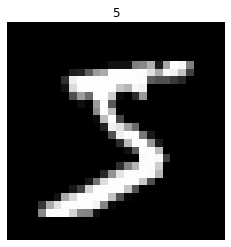

In [9]:
import matplotlib.pyplot as plt
img, label = train_dataset[0]
plt.title(f'{label}')
plt.axis("off")
plt.imshow(img.squeeze(), cmap ='gray')
plt.show()

In [10]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: dataset/
    Split: Test
    StandardTransform
Transform: ToTensor()

# Initialize network

In [11]:
model = NN(input_size = input_size, num_classes = num_classes).to(device)

# Loss and optimizer


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# Train Network

___

In [13]:
dataiter = iter(train_loader)
inputs, labels = next(dataiter)

In [14]:
inputs.shape

torch.Size([64, 1, 28, 28])

In [15]:
labels.shape

torch.Size([64])

### 64 examples in a single batch.

### Contains single band 28*28 pixels image

In [16]:
inputs.reshape(inputs.shape[0], -1).shape

torch.Size([64, 784])

Changing the 64, 1, 28, 28 shape of array to Single array of 64 examples. (Much like flatenning the array as used in TF)
___

In [17]:
for epoch in range(num_eppochs):
  running_loss = 0.0
  for batch_idx, (data, targets) in enumerate(train_loader):
    data = data.to(device = device) # tensor to data that is used by cuda
    targets = targets.to(device = device)

    # Get to correct shape
    data = data.reshape(data.shape[0], -1)

    # forward
    scores = model(data)
    loss = criterion(scores, targets)

    # backward
    optimizer.zero_grad()
    loss.backward()

    # gradient descent or adam step
    optimizer.step()
    running_loss += loss.item()
  # display statistics
  print(f'[{epoch + 1}, {batch_idx + 1:5d}] loss: {running_loss:.5f}') 

[1,   938] loss: 385.71483
[2,   938] loss: 192.41503
[3,   938] loss: 149.75283
[4,   938] loss: 120.49186
[5,   938] loss: 101.63867
[6,   938] loss: 86.55758
[7,   938] loss: 76.23355
[8,   938] loss: 67.04068
[9,   938] loss: 60.66802
[10,   938] loss: 54.26798
